# Run These

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.feature_selection import mutual_info_regression

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit # Added TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
from decimal import Decimal
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'd', 'h', '5min', or '15min'
def run_backtest(df, freq='d'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='d'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "/workspaces/Bitcoin-Systematic-Strategies/bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

# Import Data

In [38]:
df = pd.read_parquet("data/full_dataset_feature_engineering_v2.parquet", engine="pyarrow")
df.tail()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.30,312.86,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.20,309.90,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.45,313.73,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.30,310.76,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441
2024-12-31 23:00:00,4.0,0.100000,0.150000,0.200000,0.000000,0.400000,0.0,0.000150,-434.50,301.66,...,1,0,1,0,1,1,0.213169,0.195940,0.011569,0.013286


In [7]:
# Check for null values
total_nulls = df.isnull().sum().sum()
print(f'Total null values: {total_nulls}')

Total null values: 0


# Define X and y

In [45]:
target_col_name = 'return_forward'


X = df.drop(columns=['target', 'return_forward'])
features = X.columns.tolist() # Get feature names from the corrected X

y = df[target_col_name] 

# Split Data into Training (2021-2023) and Testing (2024)

In [46]:
train_mask = (df.index >= '2021-01-01') & (df.index < '2024-01-01')
test_mask = (df.index >= '2024-01-01')

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(26274, 145), y=(26274,)
Testing set shape: X=(8784, 145), y=(8784,)


# XGBoost Regressor Parameter

*   `objective='reg:squarederror'`: This specifies the learning task and the corresponding objective function. `'reg:squarederror'` indicates regression with squared error as the loss function. XGBoost will try to minimize the squared difference between the actual and predicted values.
*   `n_estimators=100`: This is the number of gradient boosted trees to build. It's equivalent to the number of boosting rounds. More estimators can lead to better performance but also increase training time and risk of overfitting.
*   `random_state=42`: This sets the seed for the random number generator. Using a fixed `random_state` ensures that results are reproducible across different runs, as aspects like feature subsampling (if used) will be consistent.
*   `enable_categorical=True` (Removed/Default is `False`): This flag enables experimental support for `pandas.Categorical` data types. Since the categorical features in this dataset are already numerically encoded (binary 0/1), this flag is not necessary. XGBoost handles numerical features by default.

# Initialize and Train XGBoost Regressor

## Option 1: Simple Training

In [ ]:
# Initialize the XGBoost Regressor
# Parameters explained in the markdown cell above.
# Consider adding other parameters like learning_rate, max_depth, subsample, colsample_bytree etc. for tuning

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgb_reg.fit(X_train, y_train)

print("Simple model training complete.")

#  *** IMPORTANT: Decide which model to use for subsequent steps (xgb_reg or xgb_reg_es) ***
# For example, to use the simple model for predictions:
# y_pred_train = xgb_reg.predict(X_train)
# y_pred_test = xgb_reg.predict(X_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## Option 2: Training with Early Stopping
To prevent overfitting, we can use early stopping. This requires splitting the training data further into a training and validation set.

In [50]:
# Split the *training* data into a new training set and a validation set
# Use shuffle=False for time series data
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

xgb_reg_es = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000,  # Increase n_estimators significantly
    learning_rate=0.05, # Consider adding a learning rate
    early_stopping_rounds=50, # Stop if validation score doesn't improve for 50 rounds
    random_state=42
    # Add other parameters like max_depth, subsample etc. here if desired
)

# Train with early stopping
xgb_reg_es.fit(X_train_es, y_train_es,
             eval_set=[(X_val_es, y_val_es)],
             verbose=False) # Set verbose=True to see training progress

print(f"Early stopping model training complete. Best iteration: {xgb_reg_es.best_iteration}")

# *** IMPORTANT: Decide which model to use for subsequent steps (xgb_reg or xgb_reg_es) ***
# For example, to use the early stopping model for predictions:
# y_pred_train = xgb_reg_es.predict(X_train)
# y_pred_test = xgb_reg_es.predict(X_test)

Early stopping model training complete. Best iteration: 22


## Option 3: Hyperparameter Tuning with TimeSeriesSplit
Use GridSearchCV with TimeSeriesSplit to find optimal hyperparameters based on cross-validation within the training period.

### Explanation: `GridSearchCV` and `TimeSeriesSplit`

**`GridSearchCV`**:
*   **Purpose:** To find the best combination of hyperparameters for a model.
*   **How it works:** You define a 'grid' of hyperparameters and their possible values. `GridSearchCV` systematically trains and evaluates the model for *every* combination of these hyperparameters using cross-validation.
*   **Outcome:** It identifies the hyperparameter combination that yields the best performance according to a specified scoring metric (e.g., R-squared, Mean Squared Error) on the validation sets within the cross-validation process.

**`TimeSeriesSplit`**:
*   **Purpose:** A cross-validation strategy specifically designed for time series data.
*   **How it works:** Unlike standard K-Fold cross-validation which shuffles data randomly, `TimeSeriesSplit` creates folds that respect the temporal order. For each split `k`, it uses the first `k` folds as the training set and the `(k+1)`-th fold as the validation set. This ensures that the model is always trained on past data and validated on future data relative to the training period within that split.
    *   Split 1: Train [1], Validate [2]
    *   Split 2: Train [1, 2], Validate [3]
    *   Split 3: Train [1, 2, 3], Validate [4]
    *   ...

**Why `TimeSeriesSplit` instead of a simple Train/Validation split for Tuning?**

While using a single train/validation split (like in Option 2 for *early stopping*) is useful for stopping training at the right point, it's less robust for *hyperparameter tuning* compared to `TimeSeriesSplit` for a few reasons:

1.  **Robustness:** A single validation set might be unusually easy or difficult, leading you to select hyperparameters that don't generalize well to other time periods. `TimeSeriesSplit` evaluates hyperparameters across multiple, sequential validation sets, giving a more reliable estimate of how well a parameter set performs over time.
2.  **Avoiding Future Peeking:** Standard cross-validation methods (like K-Fold) shuffle data, which is incorrect for time series. Shuffling would mean training the model on data points from the future and validating on data points from the past within a fold, leading to overly optimistic results and poor real-world performance.
3.  **Simulating Deployment:** `TimeSeriesSplit` mimics a realistic scenario where you periodically retrain your model on historical data and predict the next period. Using it for hyperparameter tuning helps select parameters that are likely to perform well in such a deployment setting.

In summary, `GridSearchCV` automates the search for the best hyperparameters, and `TimeSeriesSplit` ensures this search is done correctly for time series data by respecting temporal order and providing a more robust evaluation than a single validation set.

In [ ]:
# Define parameter grid (adjust ranges as needed)
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]

}

## Add other parameters like gamma, min_child_weight, reg_alpha, reg_lambda
tscv = TimeSeriesSplit(n_splits=5) # Adjust n_splits as needed

# Initialize the Regressor
xgb_reg_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Setup GridSearchCV
# Use n_jobs=-1 to use all available CPU cores
# Use scoring='neg_mean_squared_error' or 'r2'
grid_search = GridSearchCV(estimator=xgb_reg_base, 
                           param_grid=param_grid, 
                           scoring='r2', 
                           cv=tscv, 
                           n_jobs=-1, 
                           verbose=1)

# Fit GridSearchCV - This can take a significant amount of time
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best R2 score on CV: {grid_search.best_score_:.4f}")

# Get the best estimator
best_xgb_reg = grid_search.best_estimator_

#  *** IMPORTANT: If you run this, use best_xgb_reg for predictions below ***
# y_pred_train = best_xgb_reg.predict(X_train)
# y_pred_test = best_xgb_reg.predict(X_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best R2 score on CV: -0.0068


# Predictions

**Note:** Ensure you are using the desired model (`xgb_reg`, `xgb_reg_es`, or `best_xgb_reg` from GridSearch) for making predictions.

Simple Model best

In [93]:
y_pred_train = xgb_reg.predict(X_train)
y_pred_test = xgb_reg.predict(X_test)

# Evaluate Model

In [94]:
# Evaluate on Training Data
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print("--- Training Set Evaluation ---")
print(f"Mean Squared Error (MSE): {mse_train:.6f}")
print(f"Mean Absolute Error (MAE): {mae_train:.6f}")
print(f"R-squared (R2): {r2_train:.4f}")

# Evaluate on Test Data
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("\n--- Test Set Evaluation ---")
print(f"Mean Squared Error (MSE): {mse_test:.6f}")
print(f"Mean Absolute Error (MAE): {mae_test:.6f}")
print(f"R-squared (R2): {r2_test:.4f}")

--- Training Set Evaluation ---
Mean Squared Error (MSE): 0.000018
Mean Absolute Error (MAE): 0.002990
R-squared (R2): 0.6428

--- Test Set Evaluation ---
Mean Squared Error (MSE): 0.000044
Mean Absolute Error (MAE): 0.004344
R-squared (R2): -0.4458


# Visualize Prediction Results

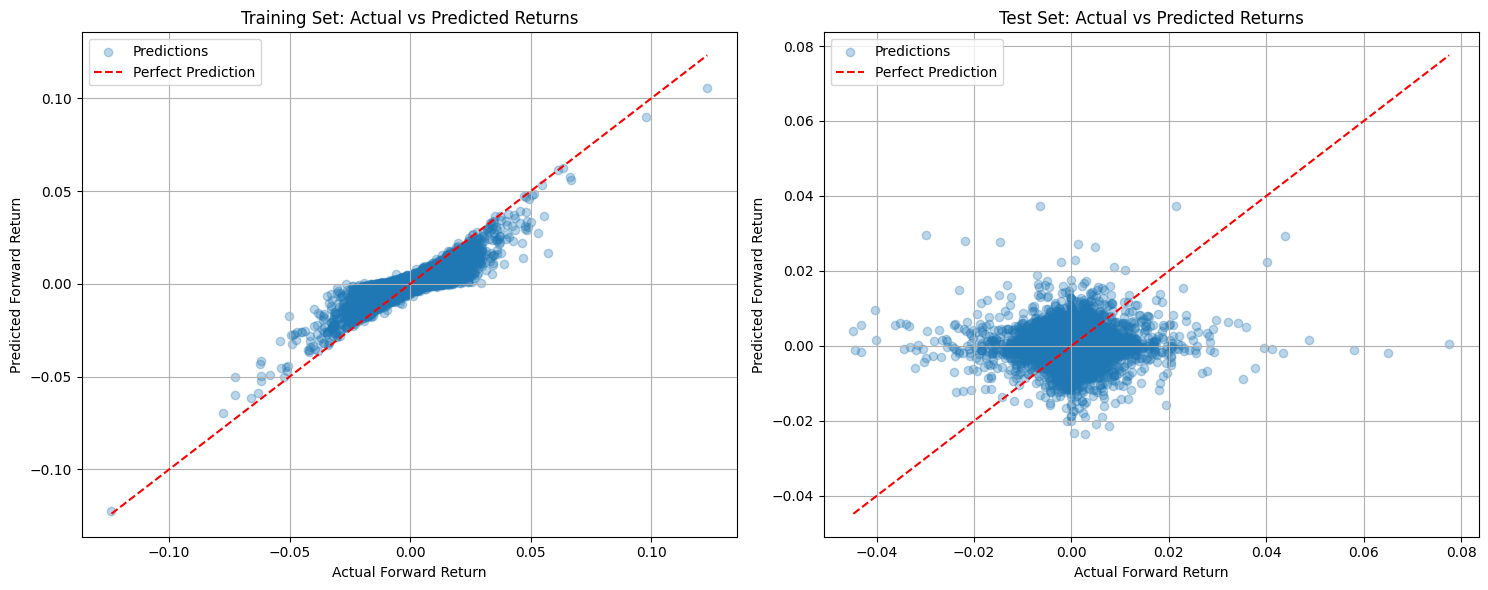

In [95]:
# 1. Predictions vs Actuals Scatter Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training Data
axes[0].scatter(y_train, y_pred_train, alpha=0.3, label='Predictions')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='red', label='Perfect Prediction')
axes[0].set_title('Training Set: Actual vs Predicted Returns')
axes[0].set_xlabel('Actual Forward Return')
axes[0].set_ylabel('Predicted Forward Return')
axes[0].legend()
axes[0].grid(True)

# Test Data
axes[1].scatter(y_test, y_pred_test, alpha=0.3, label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label='Perfect Prediction')
axes[1].set_title('Test Set: Actual vs Predicted Returns')
axes[1].set_xlabel('Actual Forward Return')
axes[1].set_ylabel('Predicted Forward Return')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

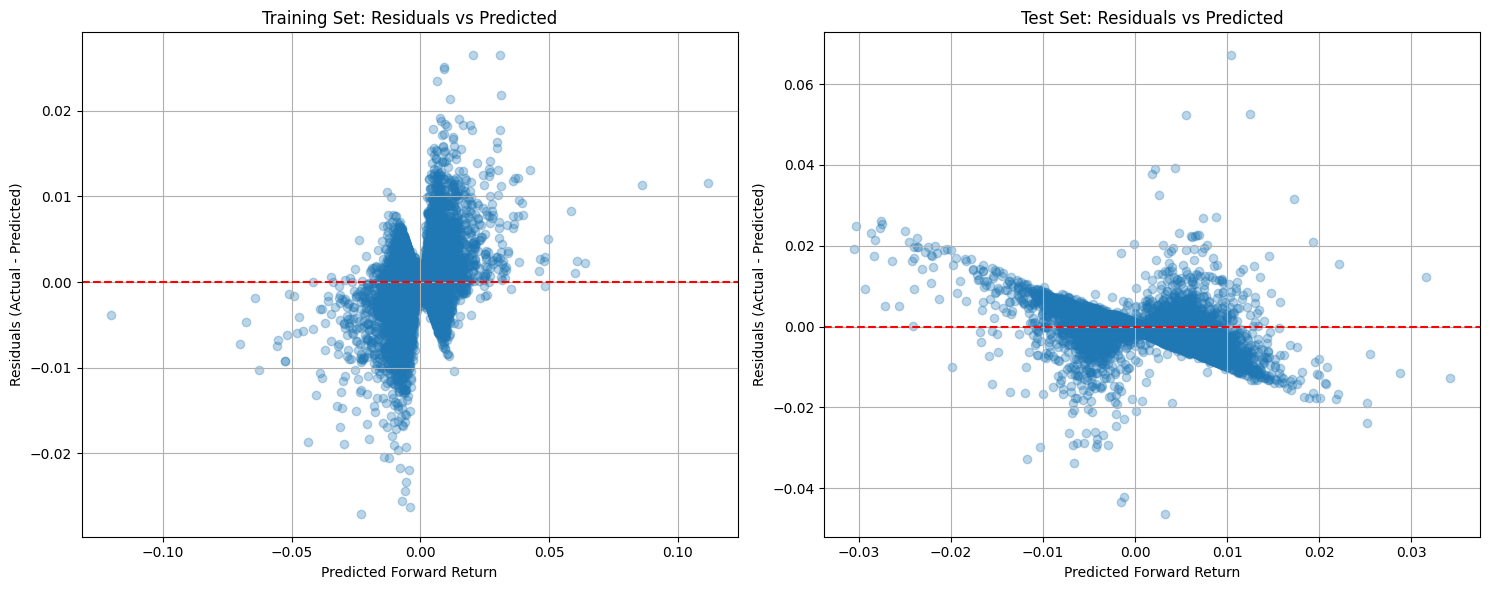

In [17]:
# 2. Residuals Plot
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training Residuals
axes[0].scatter(y_pred_train, residuals_train, alpha=0.3)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Training Set: Residuals vs Predicted')
axes[0].set_xlabel('Predicted Forward Return')
axes[0].set_ylabel('Residuals (Actual - Predicted)')
axes[0].grid(True)

# Test Residuals
axes[1].scatter(y_pred_test, residuals_test, alpha=0.3)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Test Set: Residuals vs Predicted')
axes[1].set_xlabel('Predicted Forward Return')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

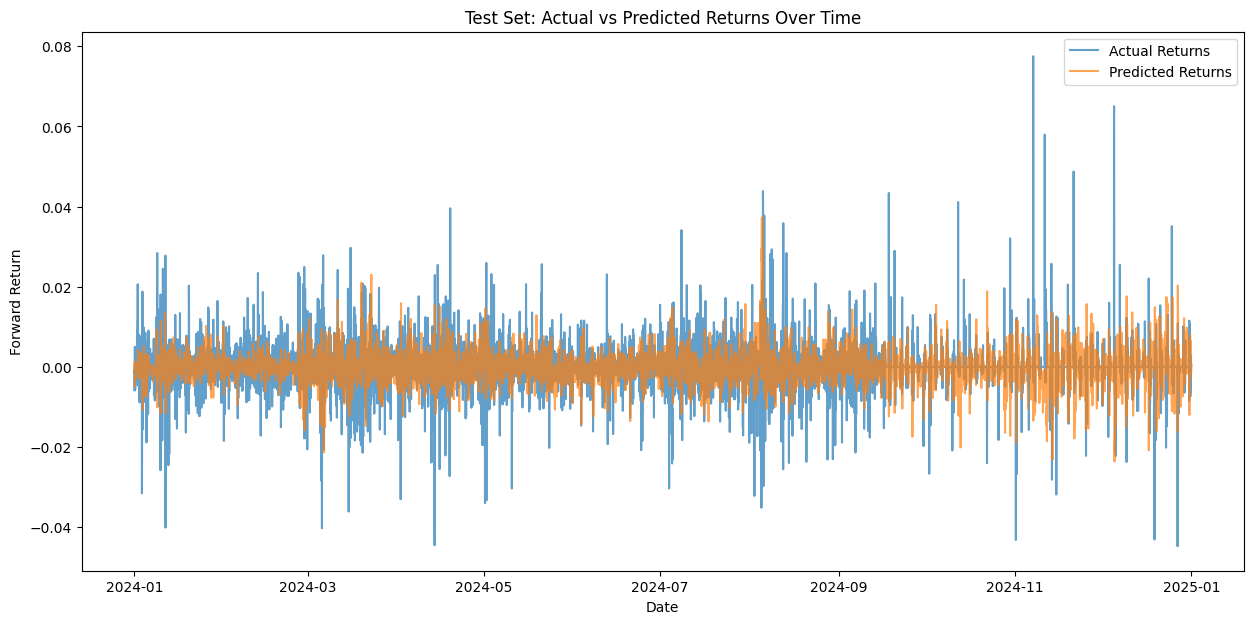

In [96]:
# 3. Predictions Over Time (Test Set)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test}, index=y_test.index)

plt.figure(figsize=(15, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual Returns', alpha=0.7)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Returns', alpha=0.7)
plt.title('Test Set: Actual vs Predicted Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Forward Return')
plt.legend()
plt.show()

# Feature Importance

Feature importance scores indicate how much each feature contributed to the model's predictions. Higher scores mean the feature was more influential.

**Note:** Ensure you are plotting importance for the model you used for prediction.

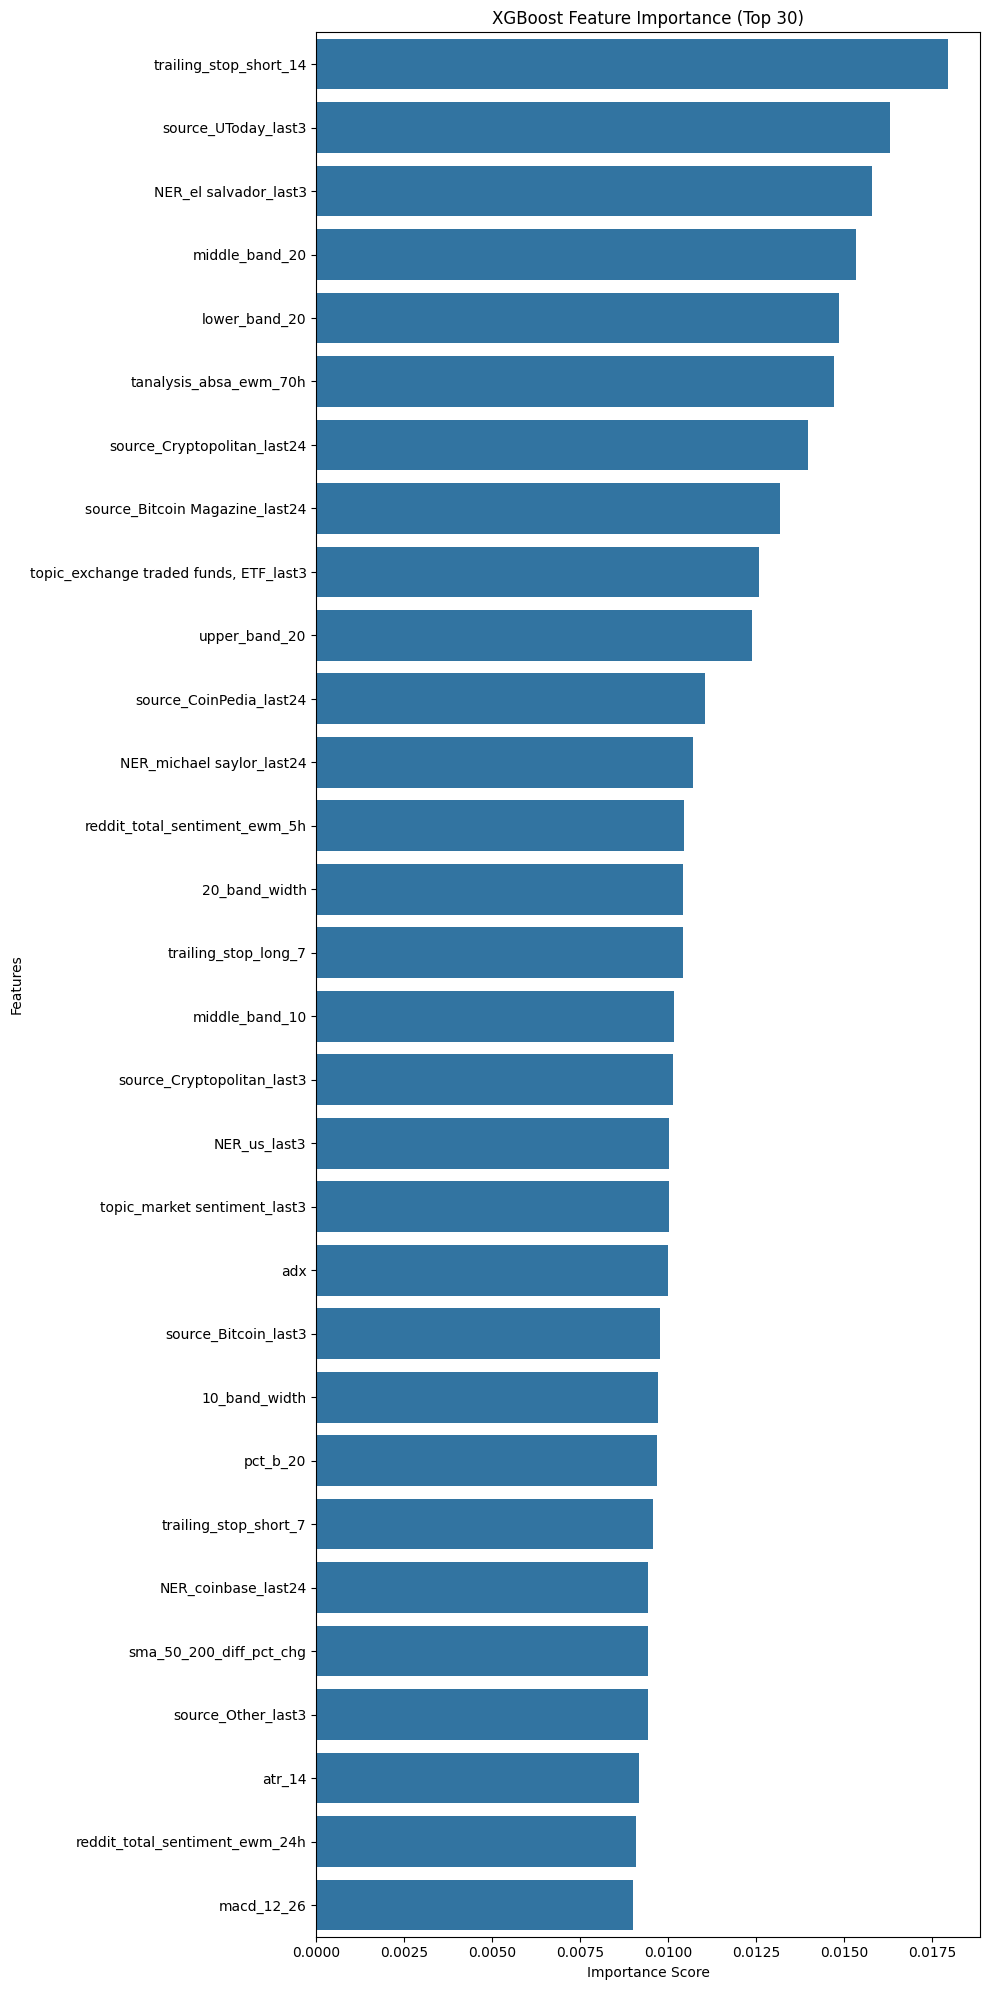

In [97]:
feature_importances = pd.Series(xgb_reg.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 20)) # Adjust figure size as needed
sns.barplot(x=feature_importances.head(30), y=feature_importances.head(30).index) # Display top 30
plt.title('XGBoost Feature Importance (Top 30)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Further Steps to Consider

1.  **Feature Selection:** Based on the feature importance plot, consider removing features with very low importance scores and retraining the model. This can sometimes reduce noise and improve generalization.
2.  **Feature Scaling:** Although XGBoost is generally robust to feature scaling, sometimes scaling features (e.g., using `StandardScaler` or `MinMaxScaler` from scikit-learn) before training can help, especially if using regularization.
3.  **More Extensive Tuning:** Explore a wider range of hyperparameters or use `RandomizedSearchCV` if `GridSearchCV` is too computationally expensive.
4.  **Analyze Residuals:** Look for patterns in the residual plots. If residuals show patterns (e.g., increasing variance), it might indicate model misspecification or non-constant variance in the errors (heteroscedasticity).
5.  **Check Data Stationarity:** Ensure that the time series features used are stationary. Non-stationary data can lead to unreliable models.

# Backtest

In [98]:
y_pred_test

array([ 0.00019784, -0.00032524, -0.00017258, ...,  0.00019698,
        0.00067408, -0.00119569], shape=(8784,), dtype=float32)

In [99]:
signal = pd.DataFrame(y_pred_test, index=X_test.index, columns=['pred_ret'])
signal['signal'] = np.where(signal['pred_ret'] > 0.001, 1, 
                            np.where(signal['pred_ret'] < -0.001, -1, 0)) 

print(signal['signal'].value_counts())

signal

signal
 0    3078
-1    2960
 1    2746
Name: count, dtype: int64


,pred_ret,signal
2024-01-01 00:00:00,0.000198,0
2024-01-01 01:00:00,-0.000325,0
2024-01-01 02:00:00,-0.000173,0
2024-01-01 03:00:00,0.001311,1
2024-01-01 04:00:00,-0.004877,-1
...,...,...
2024-12-31 19:00:00,-0.002469,-1
2024-12-31 20:00:00,-0.001970,-1
2024-12-31 21:00:00,0.000197,0
2024-12-31 22:00:00,0.000674,0


Overall Annual Return: 157.94%
Overall Annual Sharpe Ratio: 2.3123
Maximum Drawdown: -25.61 %
Alpha: 1.7284
Beta: 0.0506

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.579444     0.45446     0.050585      1.003762       2.312306


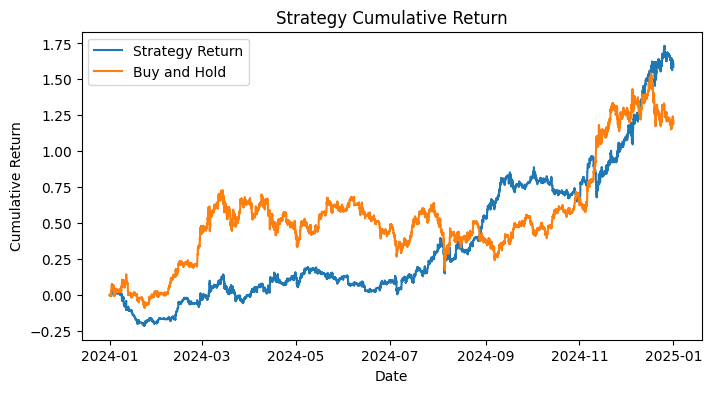

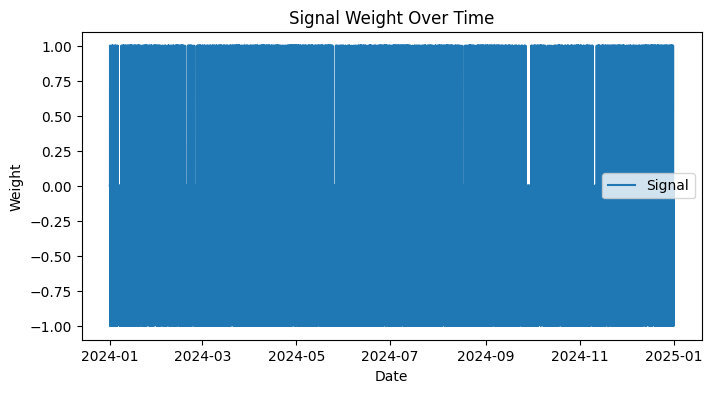

In [100]:
run_backtest(signal, freq='h')